# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 3/6/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that will predict the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  


<hr></hr>
  


In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os as os

# Data preprocessing
<hr></hr>  

I am starting with a folder containing all the images and their corresponding annotations as well as a csv that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images.

<hr></hr>

In [22]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")

In [23]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


### Splitting data into training, testing, and validation groups.

<hr></hr>

My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%

<hr></hr>

In [31]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [25]:
X_val.head()

175    WIN_20250208_18_41_30_Pro.jpg
356    WIN_20250220_20_00_48_Pro.jpg
199    WIN_20250208_18_42_00_Pro.jpg
337    WIN_20250220_19_59_07_Pro.jpg
123    WIN_20250208_18_40_29_Pro.jpg
Name: file_name, dtype: object

In [32]:
y_val.head()

,x1,y1,x2,y2
57,313,137,347,167
315,297,173,314,195
268,327,149,350,172
14,272,138,293,164
215,287,159,300,179


### Converting images and boundry data to arrays and normalizing
<hr></hr>  

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that hanles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 

<hr></hr>

#### Creating functions

In [27]:
# may not need to resize the image if I use the fast r-cnn with tensorflow
def resize_image(image):
    image = tf.image.resize(image, [224, 224])
    return image

def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
        It also normalizes the pixel values to be between 0 and 1.
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        img_path = cwd + '\\image_data\\' + df['file_name'][i]
        image = tf.keras.utils.load_img(img_path)
        # image = resize_image(image) # resizing
        image_as_arr = tf.keras.utils.img_to_array(image)/255.0
        X_data.append(image_as_arr)
    return np.array(X_data)


In [28]:
def bounds_to_arr(y):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    img_width = 640.0
    img_hight = 360.0
    y_data = []
    for i in range(len(y)):
        y_data.append((y.iloc[i].iloc[0]/img_width, y.iloc[i].iloc[1]/img_hight, y.iloc[i].iloc[2]/img_width, y.iloc[i].iloc[3]/img_hight))
    return np.array(y_data)

#### Executing functions

In [29]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)

#### Visualizing data after preprocessing is complete

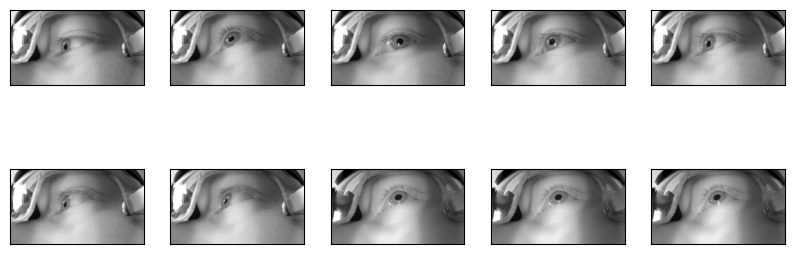

In [30]:
#code is from tensorflow website
#https://www.tensorflow.org/tutorials/images/cnn

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

## Selecting and Building a Model

<hr></hr>

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made one edit to the code and changed the loss funciton to mean squared error since my output layer is of size 4. 

<hr></hr>

#### Running a Simple Convolutional Neural Network for Experimentation

In [12]:
#one edit I made was to change the loss funciton to mean squared error.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError,
             metrics=['accuracy'])
model.summary(line_length=80)

c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                   │ (None, 358, 638, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)      │ (None, 179, 319, 32)     │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                 │ (None, 177, 317, 64)     │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 88, 158, 64)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                 │ (None, 86, 156, 64)      │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 43, 78, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                 │ (None, 41, 76, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 20, 38, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                 │ (None, 18, 36, 128)      │       147,584 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)    │ (None, 9, 18, 128)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten (Flatten)                 │ (None, 20736)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1024)             │    21,234,688 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                   │ (None, 4)                │         4,100 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 21,516,548 (82.08 MB)

 Trainable params: 21,516,548 (82.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=20)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 629ms/step - accuracy: 0.3648 - loss: 0.0557 - val_accuracy: 0.4595 - val_loss: 0.0483
Epoch 2/20
25/28 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.3981 - loss: 0.0475

KeyboardInterrupt: 

[]

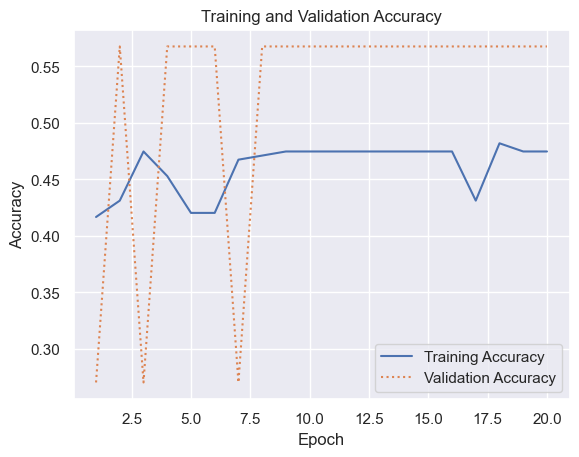

In [ ]:
import seaborn as sns
sns.set()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

<hr></hr>  

Running this test model provided a solid starting point and helped refine my focus. I found that training a CNN on large 360x640 images is inefficient. Initially, I considered cropping images to highlight the target object before resizing, but this is time-consuming. Instead, I can use a region-based CNN (R-CNN), which employs a region proposal layer to select relevant portions of the image for processing rather than analyzing the entire image at once.  

Next, I plan to build a Faster R-CNN, the most efficient variant with the lowest latency. Unlike standard or Fast R-CNN, which allow manual region selection, Faster R-CNN automatically determines regions. If necessary, I can later test predefined regions with the Fast R-CNN for better results.  

I may also explore the YOLO (You Only Look Once) object detection model, which has the lowest latency among detection models. Like R-CNN, YOLO partitions the image before processing, making it a strong candidate for my application.

<hr></hr>

#### Creating a Faster Region-based Convolutional Neural Network  
<hr></hr>

Faster R-CNN structure:  
- <b>Backbone network</b> - A pre-trained CNN used as a feature extractor. This network processes the entire input image to get a rich feature map that subsequently encodes the hierarchical visual information.  
- <b>Region Proposal Network (RPN)</b> - Takes in the feature map produced by the backbone network and predicts multiple region proposals based on it. Each region is given a score on how likely an object might be present. The RPN uses <b>anchors</b> which are predefined boxes of differing scale centered at each location in the feature map. For each anchor the RPN does two things. First it assigns the score of how likely an object is present. Second it refines the bounds to better fit the object.  
- <b>Region of Interest pooling layer</b> - 

<hr></hr>